In [1]:
# Import modules 
import sys
from os import getcwd
from os.path import dirname, join
path = dirname(dirname(getcwd()))
sys.path.append(path)

In [2]:
from MintPy.interpret_toolkit import InterpretToolkit
from MintPy.utils import (combine_top_features, 
                          save_pickle, 
                          load_pickle)
import plotting_config 
import pandas as pd
import numpy as np
from joblib import load

# Load in Models and Data

To show case the permutation importance method, we are using the road surface temperature dataset from Handler et al. (2020). The target value is whether the road surface temperature is above or below freezing (32 F). This dataset has 100 K examples with a class skew of 39%. 


Reference: 
Handler, S. L., H. D. Reeves, and A. McGovern, Development of a Probabilistic Subfreezing Road Temperature Nowcast and Forecast Using Machine Learning. Wea. Forecasting, doi: https://doi.org/10.1175/WAF-D-19-0159.1.


In [3]:
# Load the model objects. In this case, we are using two popular scikit-learn tree-based methods.
model_filepath = join(getcwd(), 'models')
model_fname = ['RandomForestClassifier.pkl',  'GradientBoostingClassifier.pkl']
model_names = ['Random Forest', 'Gradient Boosting']
model_objs = [load(join(model_filepath, fname)) for fname in model_fname]

#Import the training dataset
data_filename = join(getcwd(), 'data', 'data_for_mintpy.csv')

# Load the examples the models were trained on.
TARGET_COLUMN = 'cat_rt'
data  = pd.read_csv(data_filename)

examples = data[plotting_config.cols_to_use]
targets = data[TARGET_COLUMN].values

print(f'Examples Shape : {examples.shape}')
print(f'Target Skew : {targets.mean()*100}%')


Examples Shape : (100000, 30)
Target Skew : 39.173%


# Initializing InterpretToolkit

To initialize `InterpretToolkit`, requires a pre-fit model object (or multiple models) in one of the following formats: 
* a single pre-fit model object
* list of pre-fit model objects
* A dict of model objects with model names as the key

and examples and targets to evaluate the model(s) on. The examples and targets can be `pandas.DataFrame` or `numpy.array`. If use an array, however, then you must provide the feature names (`'feature_names'`). 

In [4]:
myInterpreter = InterpretToolkit(model=model_objs,
                                 model_names=model_names,
                                 examples=examples,
                                 targets=targets,
                                )

# Permutation Importance

Predictor ranking is often a first step in model interpretability. Permutation importance is a popular model-agnostic method for determining predictor ranking. MintPy uses a stripped-down version of the python package `PermutationImportance` (see https://permutationimportance.readthedocs.io/en/latest/ for additional details). The variation we use is known as the multi-pass permutation importance method (Lakshmanan et al. 2015, JOAT; see Fig.2 @ https://permutationimportance.readthedocs.io/en/latest/methods.html#permutation-importance for a illustration).  The main arguments are the number of important predictors to compute for (`'n_vars'`) and the evaluation function used. 

MintPy has 3 built-in error metrics for evaluating predictor importance: 
* Area under the Curve (`'auc'`)
* Area under the Performance Diagram (`'aupdc'`)
* Brier Skill Score (`'bss'`)


`'evaluation_fn'` can also be any user-defined function of the form 
`evaluation_fn(targets,predictions)` where a single value is returned. 
However, when using your own function, then you must also set the scoring strategy. If a metric is positively-oriented (a higher value is better), then set `scoring_strategy = "argmin_of_mean"` and if is negatively-oriented-oriented (a lower value is better), then set `scoring_strategy = "argmax_of_mean"`. 

 
Additional options for permutation importance include: 
* Performing bootstraping for confidence interval on predictor ranking (`nbootstrap`)
* Using multiple processors for parallelization and speedier results (`njobs`)
* Subsampling the examples for speedier results (`subsample`)

In this example, we want the computing the top 5 predictors using AUC as our error metric and using bootstrapping for confidence intervals. 

In [5]:
results = myInterpreter.permutation_importance(
                                               n_vars=10, 
                                               evaluation_fn='auc', 
                                               nbootstrap=10, 
                                               subsample=0.5,
                                               njobs=9
                                              )

"\nresults = myInterpreter.permutation_importance(\n                                               n_vars=10, \n                                               evaluation_fn='auc', \n                                               nbootstrap=10, \n                                               subsample=0.5,\n                                               njobs=9\n                                              )\n"

Once we have the results, we can save them to a pickle file and then load them for later use. When we reload the pickle file, it is important to use the `.set_results` method in `InterpretToolkit` to appropriately set the results as an class attribute. 

In [6]:
results_filepath = join(getcwd(), 'results')

# Save the permutation importance results as a pickle file
#save_pickle(fname=join(results_filepath,'multipass_importance.pkl'),
#           data=results)

# Load the permutation important results from the saved pickle file
results = load_pickle(fnames=join(results_filepath,'multipass_importance.pkl'))

# Set the permutation importance results as class attribute (for plotting purposes)
myInterpreter.set_results(results=results, 
                          option='permutation_importance'
                         )

# Plotting Single-Pass Permutation Importance 

The PermutationImportance method automatically calculates the single-pass permutation importance method. To plot the single-pass results, simply set the `multipass=False`. Note that the single-pass includes the ranking of every single predictors, so for readability, you can set `num_vars_to_plot`.

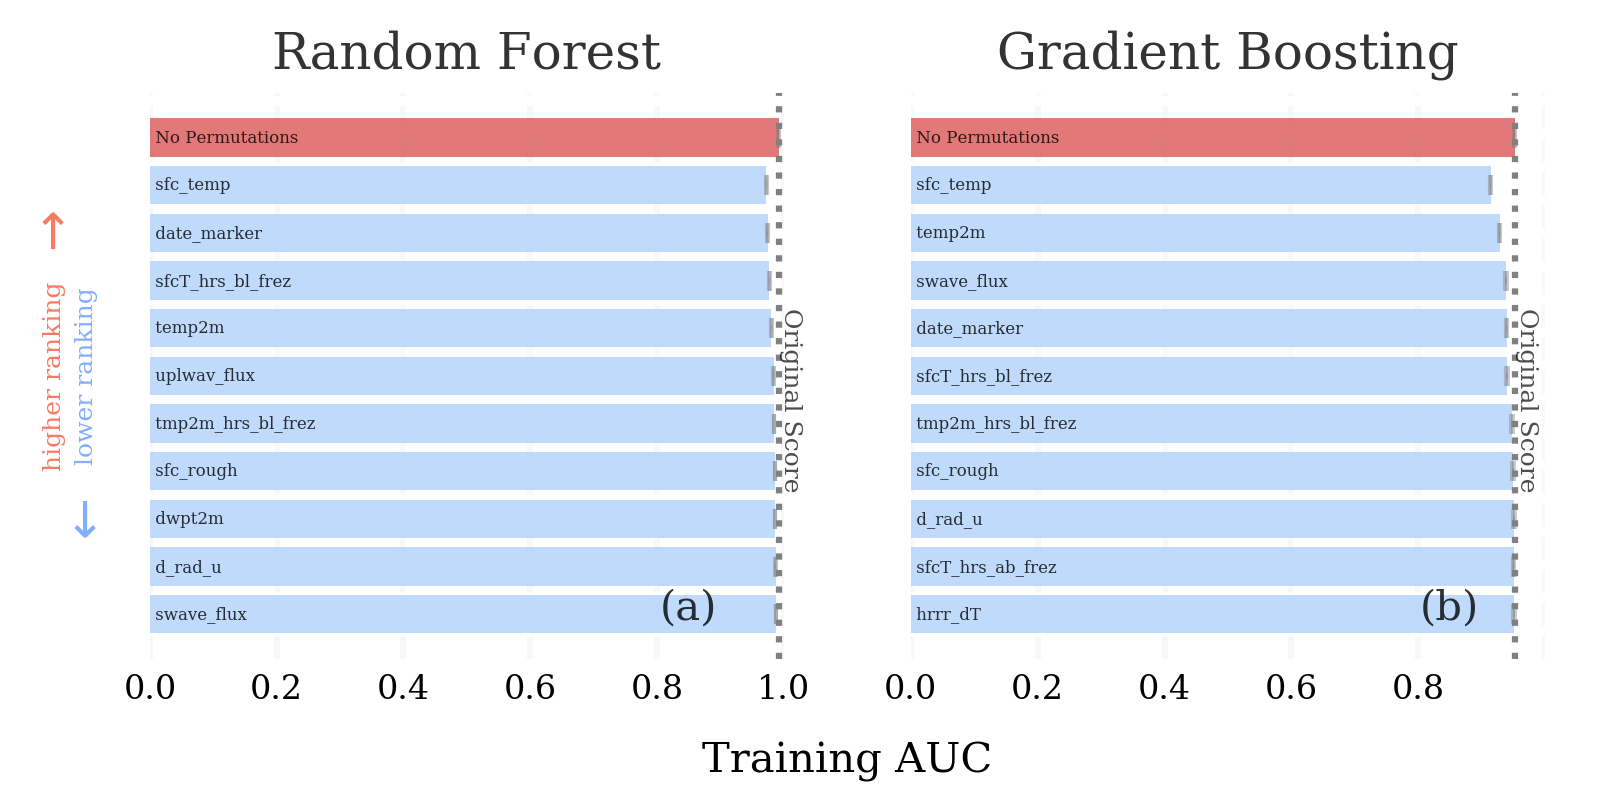

In [7]:
fig = myInterpreter.plot_importance(multipass=False, 
                                    metric ="Training AUC", 
                                    num_vars_to_plot=10,
                                    feature_colors=None,
                                   )

# Plotting Multi-Pass Permutation Importance 

To plot the multi-pass results, set the `multipass=True`. 


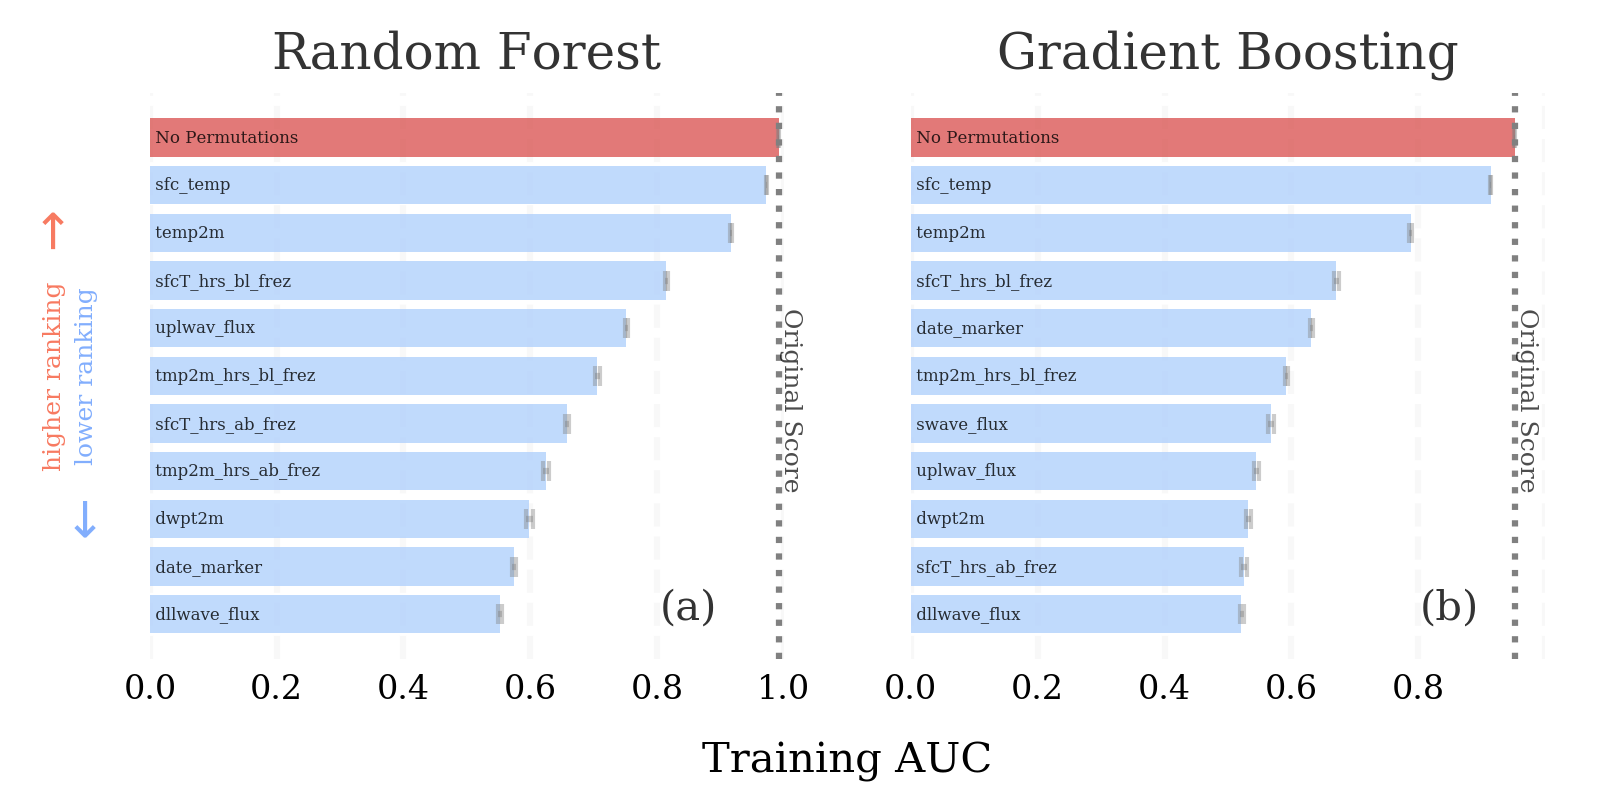

In [10]:
fig = myInterpreter.plot_importance(multipass=True, 
                                    metric = "Training AUC", 
                                   )

## Plotting Permutation Importance (with Color Coding and Readable Predictor Names)

To personalize your plots, you can pass a dict `readable_feature_names`, which maps the stored predictor name with a prettier, more interpretable name. Additionally, you can color code your predictors with `feature_colors`, which maps the stored feature names to a color (see https://i.stack.imgur.com/nCk6u.jpg for a extension map of named colors in python). 

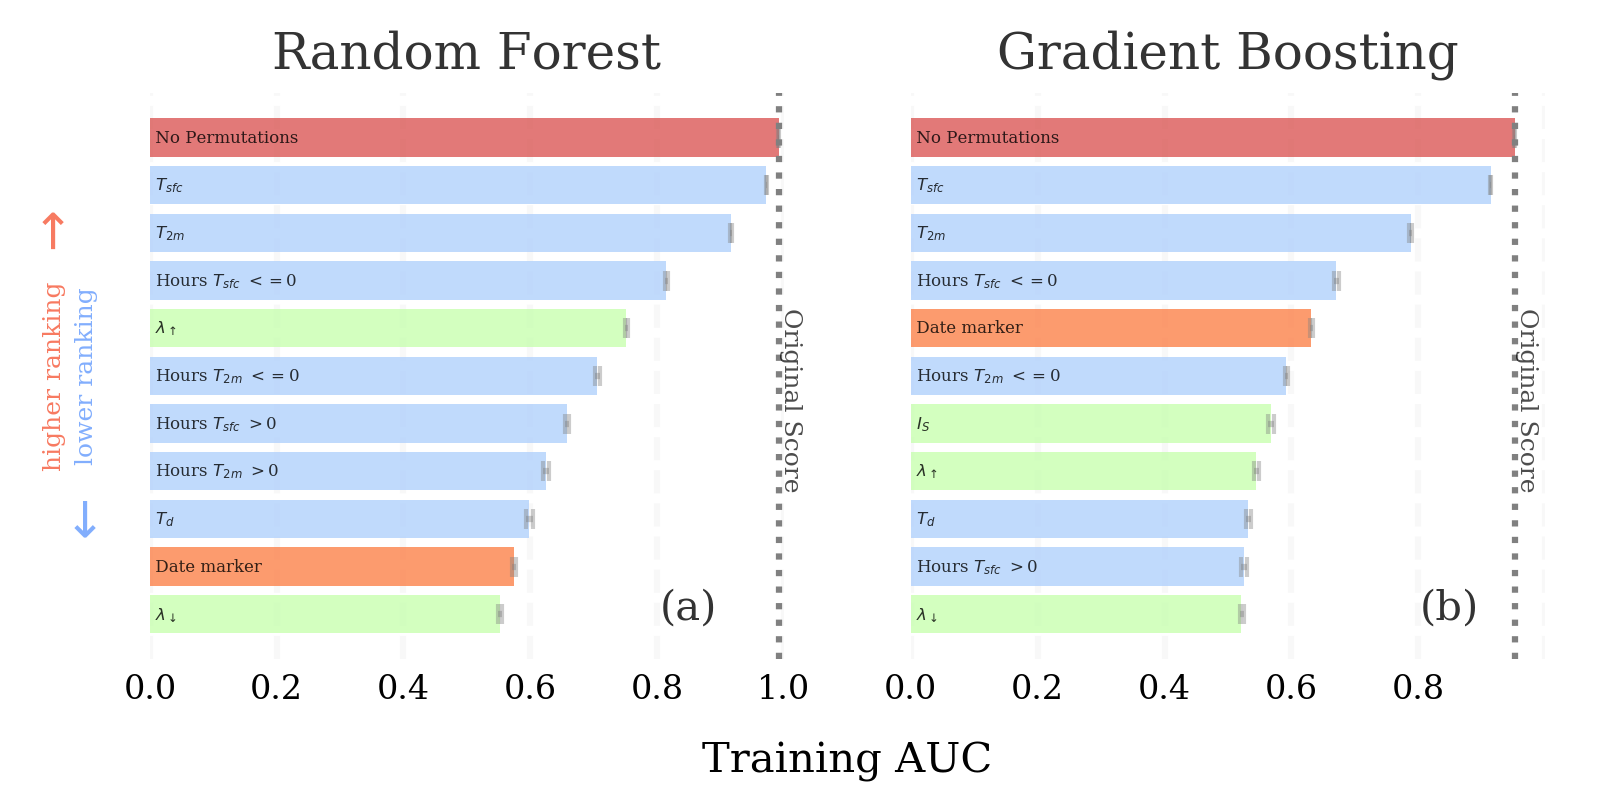

In [12]:
fig = myInterpreter.plot_importance(multipass=True, 
                                    metric = "Training AUC", 
                                    readable_feature_names=plotting_config.readable_feature_names,
                                    feature_colors=plotting_config.color_dict,
                                   )

# Saving your figure 

In [9]:
# Saving the figures
myInterpreter.save_figure(fig=fig, 
                          fname='multipass_perm_importance.png', 
                          bbox_inches="tight", 
                          dpi=300, aformat="png")